## Loading the model

In [6]:
dim_recurrent = 100
simple_input = False
simple_output = True
reg_norm = 0.00005
reg_lam = 2
noise = 0.1
hold_zero=False
init_random = "C1"
parameter_updates = 100000 # 0 = best network overall
redo_preanalysis = None # None = redo only if necessary

ORI_RES = 3

%run -i 'playground_prepare.py'

In [267]:
t1, t1d = -1+delay0, "before O1 presented"
t1_5, t1_5d = -1+delay0+hold_orientation_for//2, "amid 01 presentation"
t2, t2d = -1+delay0+hold_orientation_for, "after O1 presented"
t3, t3d = -1+delay0+hold_orientation_for+delay1, "before O2 presented"
t4, t4d = -1+delay0+hold_orientation_for+delay1+hold_orientation_for, "after O2 presented"
t5, t5d = -1+delay0+hold_orientation_for+delay1+hold_orientation_for+delay2, "before go cue"
t6, t6d = -1+total_time, "end of task"

## Tunings of neurons

In [1]:
# s['var'] is (variance in O1 + 0.01)/(variance in O2 + 0.01)
# thus, for highly tuned units, s['var']+1/s['var'] is big. 
# for DT units, it's small. 10 is an arbitrary threshold here.
DT_i = torch.tensor([i for i, s in enumerate(sor) if s['var']+1/s['var']<2.5])
R1_ends_at_i = min(DT_i)
R2_starts_from_i = max(DT_i)+1
R1_num = R1_ends_at_i
DT_num = len(DT_i)
R2_num = dim_recurrent - R1_num - DT_num

NameError: name 'torch' is not defined

In [2]:
images_side_by_side((
    plt_to_image(get_tuning_heatmaps(t2, t2d, sor_i=megabatch_tuningindices[-1])),
    plt_to_image(get_tuning_heatmaps(t3, t3d, sor_i=megabatch_tuningindices[-1])),
    plt_to_image(get_tuning_heatmaps(t4, t4d, sor_i=megabatch_tuningindices[-1])),
    plt_to_image(get_tuning_heatmaps(t5, t5d, sor_i=megabatch_tuningindices[-1])),
), save_to=make_saving_path("tunings.pdf"), title=f"{R1_num} R1 - {DT_num} DT - {R2_num} R2")

NameError: name 'images_side_by_side' is not defined

## Ring->Output

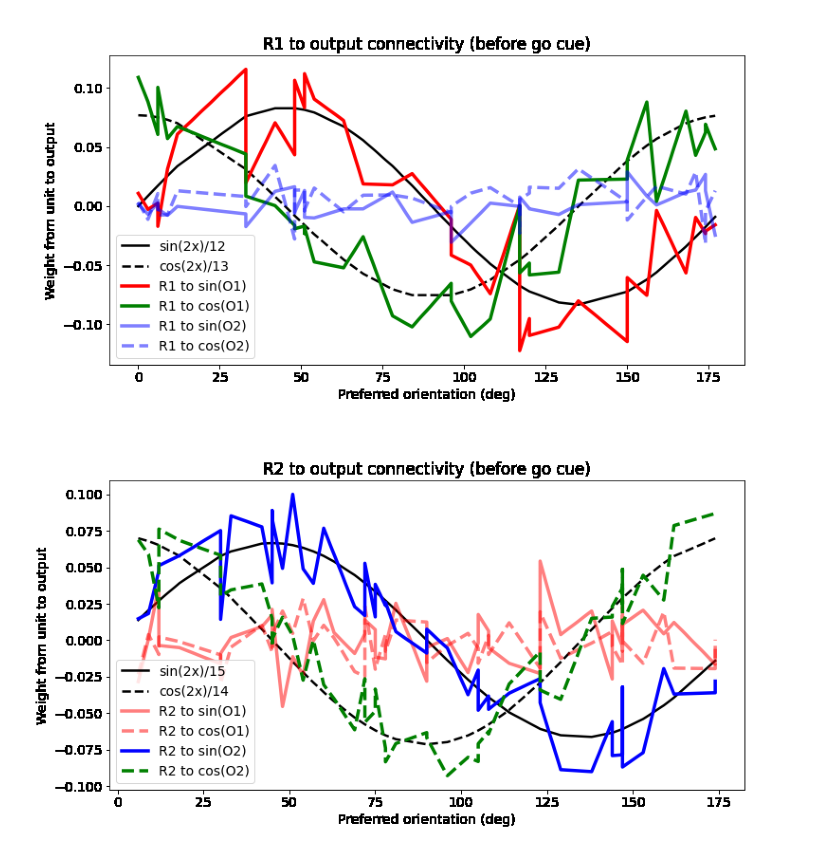

In [292]:
if simple_output:
    timestep = t5
    timestep_description = t5d
    R1_i = megabatch_tuningindices[timestep][:R1_ends_at_i]
    R2_i = megabatch_tuningindices[timestep][R2_starts_from_i:]
    R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
    R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
    #sort units within R1 and R2 by preferred angle
    R1_i = R1_i.clone()[torch.argsort(R1_pref)]
    R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
    R2_i = R2_i.clone()[torch.argsort(R2_pref)]
    R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]

    # find closest sin and cos
    min_k_sin, min_k_cos, min_err_sin, min_err_cos = -1, -1, 1e10, 1e10
    for k in range(20):
        err = torch.sum((model.fc_h2y.weight[:, R1_i][0]-torch.sin(R1_pref/180*3.14*2)/k)**2)
        if err<min_err_sin: min_k_sin=k;min_err_sin=err
        err = torch.sum((model.fc_h2y.weight[:, R1_i][1]-torch.cos(R1_pref/180*3.14*2)/k)**2)
        if err<min_err_cos: min_k_cos=k;min_err_cos=err
    plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
    fig = plt.figure(figsize=(12, 6))
    plt.plot(R1_pref.cpu().detach().numpy(), torch.sin(R1_pref/180*3.14*2).cpu().detach().numpy()/min_k_sin, 
             "k-", linewidth=2.5, label=f"sin(2x)/{min_k_sin}")
    plt.plot(R1_pref.cpu().detach().numpy(), torch.cos(R1_pref/180*3.14*2).cpu().detach().numpy()/min_k_cos, 
             "k--", linewidth=2.5, label=f"cos(2x)/{min_k_cos}")
    plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][0].cpu().detach().numpy(), 
             "r-", linewidth=3.5, label="R1 to sin(O1)")
    plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][1].cpu().detach().numpy(), 
             "g-", linewidth=3.5, label="R1 to cos(O1)", alpha=1)
    plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][2].cpu().detach().numpy(), 
             "b-", linewidth=3.5, label="R1 to sin(O2)", alpha=0.5)
    plt.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][3].cpu().detach().numpy(), 
             "b--", linewidth=3.5, label="R1 to cos(O2)", alpha=0.5)

    #plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
    #plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
    plt.xlabel('Preferred orientation (deg)')
    plt.ylabel('Weight from unit to output')
    plt.title(f'R1 to output connectivity ({timestep_description})')
    plt.legend()
    im1 = plt_to_image(fig)

    # find closest sin and cos
    min_k_sin, min_k_cos, min_err_sin, min_err_cos = -1, -1, 1e10, 1e10
    for k in range(20):
        err = torch.sum((model.fc_h2y.weight[:, R2_i][2]-torch.sin(R2_pref/180*3.14*2)/k)**2)
        if err<min_err_sin: min_k_sin=k;min_err_sin=err
        err = torch.sum((model.fc_h2y.weight[:, R2_i][3]-torch.cos(R2_pref/180*3.14*2)/k)**2)
        if err<min_err_cos: min_k_cos=k;min_err_cos=err
    fig = plt.figure(figsize=(12, 6))
    plt.plot(R2_pref.cpu().detach().numpy(), torch.sin(R2_pref/180*3.14*2).cpu().detach().numpy()/min_k_sin, 
             "k-", linewidth=2.5, label=f"sin(2x)/{min_k_sin}")
    plt.plot(R2_pref.cpu().detach().numpy(), torch.cos(R2_pref/180*3.14*2).cpu().detach().numpy()/min_k_cos, 
             "k--", linewidth=2.5, label=f"cos(2x)/{min_k_cos}")
    plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][0].cpu().detach().numpy(), 
             "r-", linewidth=3.5, label="R2 to sin(O1)", alpha=0.5)
    plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][1].cpu().detach().numpy(), 
             "r--", linewidth=3.5, label="R2 to cos(O1)", alpha=0.5)
    plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][2].cpu().detach().numpy(), 
             "b-", linewidth=3.5, label="R2 to sin(O2)")
    plt.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][3].cpu().detach().numpy(), 
             "g--", linewidth=3.5, label="R2 to cos(O2)")
    #plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
    #plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
    plt.xlabel('Preferred orientation (deg)')
    plt.ylabel('Weight from unit to output')
    plt.title(f'R2 to output connectivity ({timestep_description})')
    plt.legend()
    im2 = plt_to_image(fig)

    images_side_by_side((im1, im2), vert_pref=True, figsize=(12, 12), save_to=make_saving_path("ring_output_connectivity.pdf"))

## Clustering

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


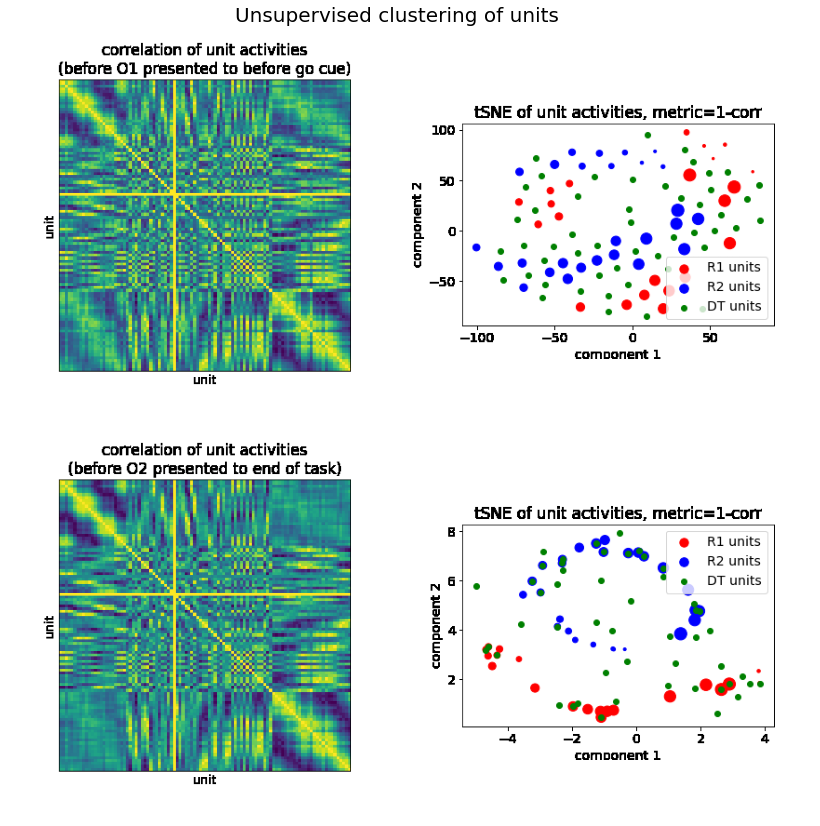

In [273]:
t_from, t_from_d = t1, t1d
t_to, t_to_d = t5, t5d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
#corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"correlation of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im1 = plt_to_image(fig)

tsne = TSNE(2, metric='precomputed', init='random', learning_rate='auto')
tsne_result = tsne.fit_transform(1-(corr))
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"tSNE of unit activities, metric=1-corr")
plt.legend()
im2 = plt_to_image(fig)

t_from, t_from_d = t3, t3d
t_to, t_to_d = t6, t6d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
#corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"correlation of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im3 = plt_to_image(fig)

tsne = TSNE(2, metric='precomputed', init='random', learning_rate='auto')
tsne_result = tsne.fit_transform(1-(corr))
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"tSNE of unit activities, metric=1-corr")
plt.legend()
im4 = plt_to_image(fig)

images_side_by_side((
    im1, im2, im3, im4
), save_to=make_saving_path("clustering.pdf"), title=f"Unsupervised clustering of units")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


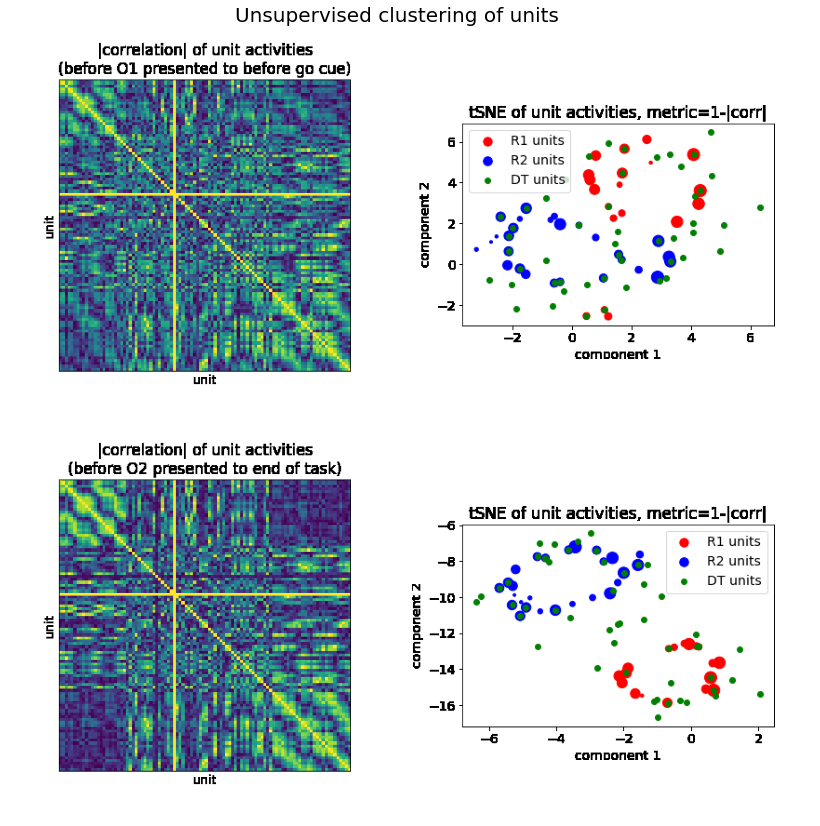

In [274]:
t_from, t_from_d = t1, t1d
t_to, t_to_d = t5, t5d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"|correlation| of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im1 = plt_to_image(fig)

tsne = TSNE(2, metric='precomputed', init='random', learning_rate='auto')
tsne_result = tsne.fit_transform(1-(corr))
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"tSNE of unit activities, metric=1-|corr|")
plt.legend()
im2 = plt_to_image(fig)

t_from, t_from_d = t3, t3d
t_to, t_to_d = t6, t6d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"|correlation| of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im3 = plt_to_image(fig)

tsne = TSNE(2, metric='precomputed', init='random', learning_rate='auto')
tsne_result = tsne.fit_transform(1-(corr))
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"tSNE of unit activities, metric=1-|corr|")
plt.legend()
im4 = plt_to_image(fig)

images_side_by_side((
    im1, im2, im3, im4
), save_to=make_saving_path("clustering_abs.pdf"), title=f"Unsupervised clustering of units")

In [34]:
import openTSNE

def oneminus_corr_xy(x, y):
    c = np.corrcoef(x, y)[0][1]
    return 1-c if c==c else 0
def oneminus_abs_corr_xy(x, y):
    c = np.corrcoef(x, y)[0][1]
    return 1-np.abs(c) if c==c else 0

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions

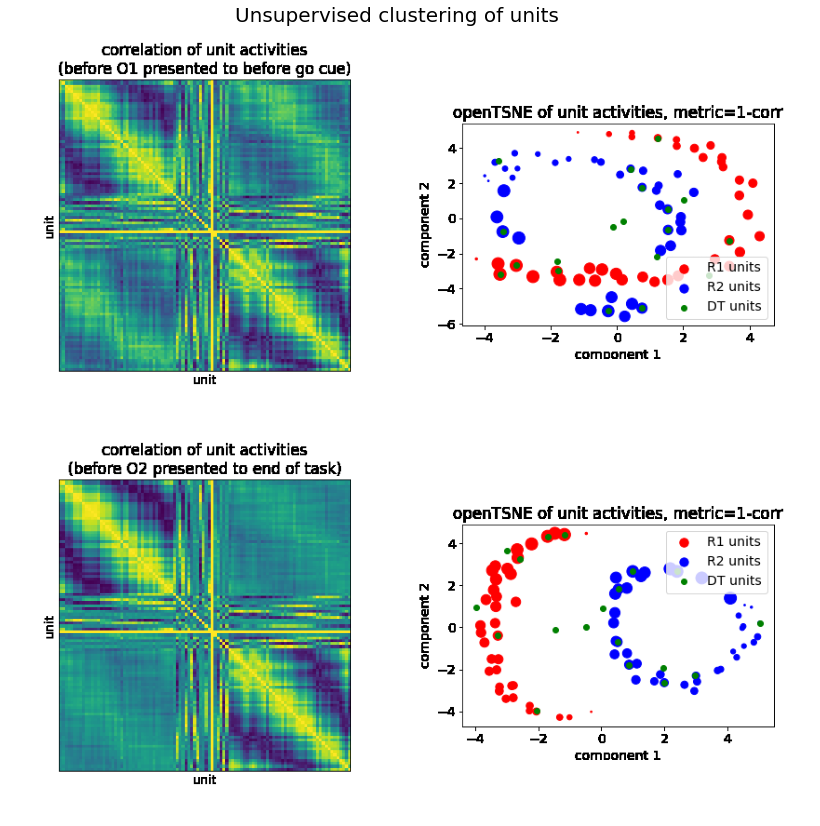

In [35]:
t_from, t_from_d = t1, t1d
t_to, t_to_d = t5, t5d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
#corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"correlation of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im1 = plt_to_image(fig)

tsne = openTSNE.TSNE(
    perplexity=30,
    metric=oneminus_corr_xy,
    n_jobs=8,
    random_state=42,
    verbose=False,
)
tsne_result = tsne.fit(arr)
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"openTSNE of unit activities, metric=1-corr")
plt.legend()
im2 = plt_to_image(fig)

t_from, t_from_d = t3, t3d
t_to, t_to_d = t6, t6d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
#corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"correlation of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im3 = plt_to_image(fig)

tsne = openTSNE.TSNE(
    perplexity=30,
    metric=oneminus_corr_xy,
    n_jobs=8,
    random_state=42,
    verbose=False,
)
tsne_result = tsne.fit(arr)
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"openTSNE of unit activities, metric=1-corr")
plt.legend()
im4 = plt_to_image(fig)

images_side_by_side((
    im1, im2, im3, im4
), save_to=make_saving_path("clustering_opentsne.pdf"), title=f"Unsupervised clustering of units")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions

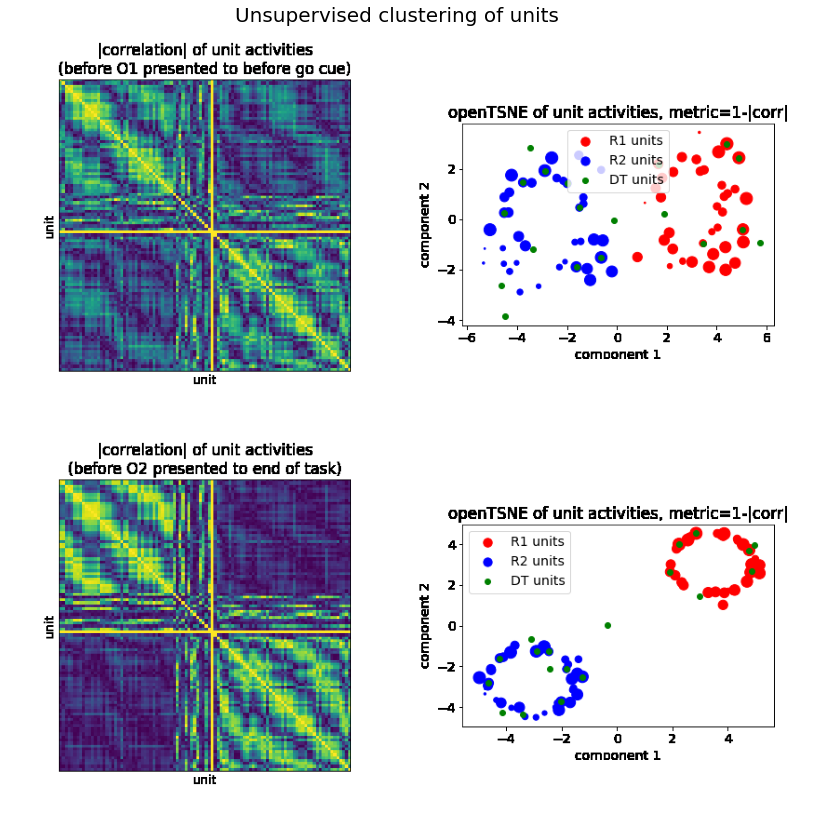

In [36]:
t_from, t_from_d = t1, t1d
t_to, t_to_d = t5, t5d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"|correlation| of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im1 = plt_to_image(fig)

tsne = openTSNE.TSNE(
    perplexity=30,
    metric=oneminus_abs_corr_xy,
    n_jobs=8,
    random_state=42,
    verbose=False,
)
tsne_result = tsne.fit(arr)
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"openTSNE of unit activities, metric=1-|corr|")
plt.legend()
im2 = plt_to_image(fig)

t_from, t_from_d = t3, t3d
t_to, t_to_d = t6, t6d
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
arr = arr[:, torch.cat((R1_i, DT_i, R2_i))]
arr = arr.T.cpu().detach().numpy()
corr = np.corrcoef(arr)
corr[corr!=corr]=1 # get rid of null values
corr = np.abs(corr)
fig = plt.figure(figsize=(6, 6))
plt.imshow(corr)
plt.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
#plt.axis('off')
plt.xlabel("unit")
plt.ylabel("unit")
plt.title(f"|correlation| of unit activities\n({t_from_d} to {t_to_d})")
plt.xticks([0, 99])
plt.yticks([0, 99])
im3 = plt_to_image(fig)

tsne = openTSNE.TSNE(
    perplexity=30,
    metric=oneminus_abs_corr_xy,
    n_jobs=8,
    random_state=42,
    verbose=False,
)
tsne_result = tsne.fit(arr)
#tsne_result.shape
fig = plt.figure()
#ax = fig.add_subplot()
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
plt.scatter(tsne_result[:len(R1_i), 0], tsne_result[:len(R1_i), 1], R1_pref, color='r', label="R1 units")
plt.scatter(tsne_result[-len(R2_i):, 0], tsne_result[-len(R2_i):, 1], R2_pref, color='b', label="R2 units")
plt.scatter(tsne_result[len(R1_i):len(R1_i)+len(DT_i), 0], tsne_result[len(R1_i):len(R1_i)+len(DT_i), 1], color='g', label="DT units")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title(f"openTSNE of unit activities, metric=1-|corr|")
plt.legend()
im4 = plt_to_image(fig)

images_side_by_side((
    im1, im2, im3, im4
), save_to=make_saving_path("clustering_opentsne_abs.pdf"), title=f"Unsupervised clustering of units")

## Ring->Ring

In [275]:
def get_connplot_graph(timestep, R1_i=None, R2_i=None, R1_pref=None, R2_pref=None, cc_smoothing=True):
    if R1_i is None:
        R1_i = megabatch_tuningindices[timestep][:R1_ends_at_i]
    if R2_i is None:
        R2_i = megabatch_tuningindices[timestep][R2_starts_from_i:]
    if R1_pref is None:
        R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
    if R2_pref is None:
        R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
    W = model.fc_h2ah.weight
    sm = 10 # size of smoothing
    distances_weights = {}
    for i in range(len(R1_i)):
        for j in range(len(R1_i)):
            if j == i: continue
            diff = (R1_pref[i]-R1_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            if not cc_smoothing: 
                diff = (diff // sm) * sm
            w_ij = W[R1_i[j], R1_i[i]] # weight from i to j 
            for c in (range(-sm//2, sm//2+1) if cc_smoothing else [0]):
                if diff+c not in distances_weights: distances_weights[diff+c] = []
                distances_weights[diff+c].append(w_ij.item())
    r1_distances = np.array(sorted(distances_weights.keys()))
    r1_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r1_distances]
    r1_weights_std = [np.std(distances_weights[diff]) for diff in r1_distances]
    distances_weights = {}
    for i in range(len(R2_i)):
        for j in range(len(R2_i)):
            if j == i: continue
            diff = (R2_pref[i]-R2_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            if not cc_smoothing: 
                diff = (diff // sm) * sm
            w_ij = W[R2_i[j], R2_i[i]] # weight from i to j 
            for c in (range(-sm//2, sm//2+1) if cc_smoothing else [0]):
                if diff+c not in distances_weights: distances_weights[diff+c] = []
                distances_weights[diff+c].append(w_ij.item())
    r2_distances = np.array(sorted(distances_weights.keys()))
    r2_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r2_distances] 
    r2_weights_std = [np.std(distances_weights[diff]) for diff in r2_distances]
    return r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std

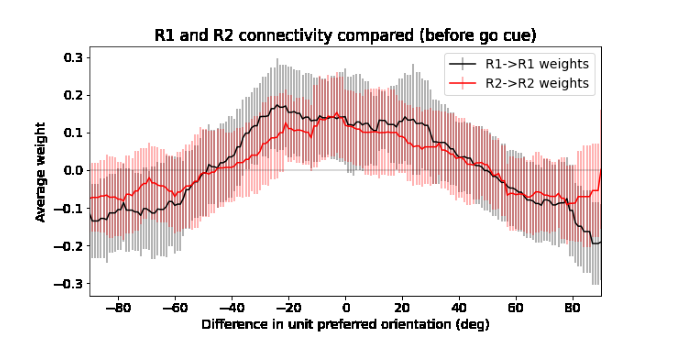

In [276]:
timestep, timestep_desc = t5, t5d
r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_graph(timestep)

fig = plt.figure(figsize=(10, 5))
markers, caps, bars = plt.errorbar(r1_distances, r1_weights, r1_weights_std, color='k', markersize=10, label="R1->R1 weights", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='r', markersize=10, label="R2->R2 weights", capsize=0)
[bar.set_alpha(0.4) for bar in bars]
[cap.set_alpha(0.4) for cap in caps]
plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
plt.xlabel('Difference in unit preferred orientation (deg)')
plt.ylabel('Average weight')
plt.title(f'R1 and R2 connectivity compared ({timestep_desc})')
plt.legend()
plt.xlim(-90, 90)
images_side_by_side((plt_to_image(fig),), figsize=(10, 5), 
                    save_to=make_saving_path("ring_connectivity.pdf"))

In [277]:
def get_connplot_r1r2_graph(timestep, R1_i=None, R2_i=None, R1_pref=None, R2_pref=None, cc_smoothing=True):
    if R1_i is None:
        R1_i = megabatch_tuningindices[timestep][:R1_ends_at_i]
    if R2_i is None:
        R2_i = megabatch_tuningindices[timestep][R2_starts_from_i:]
    if R1_pref is None:
        R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
    if R2_pref is None:
        R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES
    W = model.fc_h2ah.weight
    sm = 10 # size of smoothing
    distances_weights = {}
    for i in range(len(R1_i)):
        for j in range(len(R2_i)):
            #if j == i: continue
            diff = (R1_pref[i]-R2_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            if not cc_smoothing: 
                diff = (diff // sm) * sm
            w_ij = W[R2_i[j], R1_i[i]] # weight from i to j 
            for c in (range(-sm//2, sm//2+1) if cc_smoothing else [0]):
                if diff+c not in distances_weights: distances_weights[diff+c] = []
                distances_weights[diff+c].append(w_ij.item())
    r1_distances = np.array(sorted(distances_weights.keys()))
    r1_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r1_distances]
    r1_weights_std = [np.std(distances_weights[diff]) for diff in r1_distances]
    distances_weights = {}
    for i in range(len(R2_i)):
        for j in range(len(R1_i)):
            #if j == i: continue
            diff = (R2_pref[i]-R1_pref[j]).item()
            diff = (diff + 180 + 90) % 180 - 90
            if not cc_smoothing: 
                diff = (diff // sm) * sm
            w_ij = W[R1_i[j], R2_i[i]] # weight from i to j 
            for c in (range(-sm//2, sm//2+1) if cc_smoothing else [0]):
                if diff+c not in distances_weights: distances_weights[diff+c] = []
                distances_weights[diff+c].append(w_ij.item())
    r2_distances = np.array(sorted(distances_weights.keys()))
    r2_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in r2_distances] 
    r2_weights_std = [np.std(distances_weights[diff]) for diff in r2_distances]
    return r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std

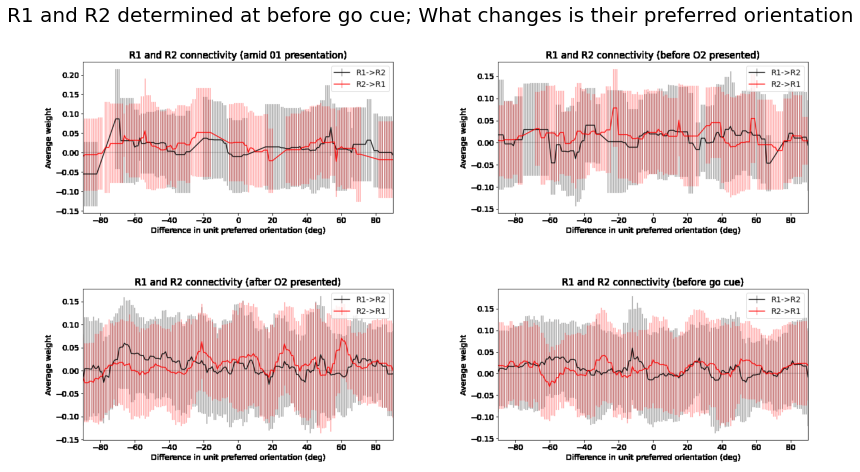

In [278]:
R1_i = megabatch_tuningindices[t5][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t5][R2_starts_from_i:]
images = []
for i, x in enumerate([(t1_5, t1_5d), (t3, t3d), (t4, t4d), (t5, t5d)]):
    timestep, timestep_desc = x
    R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
    R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES

    r1_distances, r1_weights, r1_weights_std, r2_distances, r2_weights, r2_weights_std = get_connplot_r1r2_graph(timestep, R1_i, R2_i, R1_pref, R2_pref)

    fig = plt.figure(figsize=(10, 5))
    markers, caps, bars = plt.errorbar(r1_distances, r1_weights, r1_weights_std, color='k', markersize=10, label="R1->R2", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    markers, caps, bars = plt.errorbar(r2_distances, r2_weights, r2_weights_std, color='r', markersize=10, label="R2->R1", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'R1 and R2 connectivity ({timestep_desc})')
    plt.legend()
    plt.xlim(-90, 90)
    images.append(plt_to_image(fig))
images_side_by_side(images, 
                    save_to=make_saving_path("r1_r2_connectivity.pdf"), 
                    title="R1 and R2 determined at before go cue; What changes is their preferred orientation",
                    figsize=(12, 7))

## Input->Ring

In [63]:
def get_connplot_iu_graph(units_id, unit_pref, timestep, cc_smoothing=True):
    sm = 10 # size of smoothing
    
    distances_weights = {}
    for i in range(len(units_id)):
        for j in range(orientation_neurons):
            if j == i: continue
            diff = (unit_pref[i]-round(180*j/orientation_neurons)).item()
            diff = (diff + 180 + 90) % 180 - 90
            if not cc_smoothing: 
                diff = (diff // sm) * sm
            w_ij = model.fc_x2ah.weight[units_id[i], j] # weight from i to j 
            for c in (range(-sm//2, sm//2+1) if cc_smoothing else [0]):
                if diff+c not in distances_weights: distances_weights[diff+c] = []
                distances_weights[diff+c].append(w_ij.item())
                
    o1_distances = np.array(sorted(distances_weights.keys()))
    o1_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in o1_distances]
    o1_weights_std = [np.std(distances_weights[diff]) for diff in o1_distances]
    return o1_distances, o1_weights, o1_weights_std

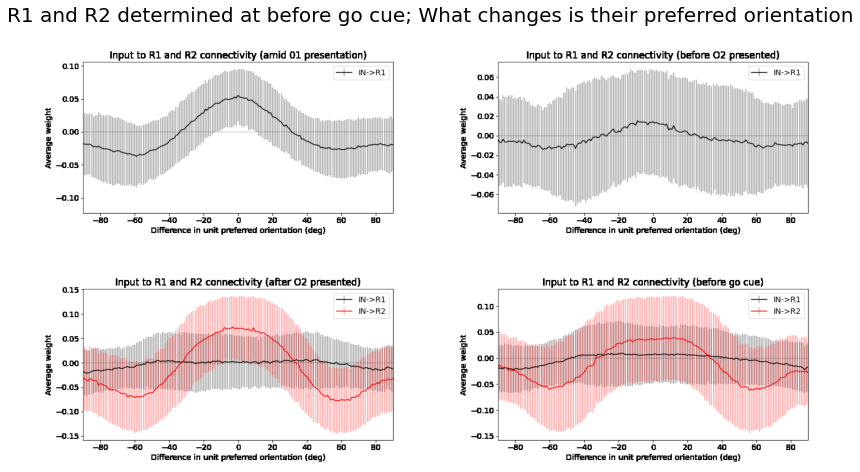

In [64]:
R1_i = megabatch_tuningindices[t5][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t5][R2_starts_from_i:]
imagess = []
for i, x in enumerate([(t1_5, t1_5d), (t3, t3d), (t4, t4d), (t5, t5d)]):
    timestep, timestep_desc = x
    R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
    R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES

    o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph(R1_i, R1_pref, timestep)
    o2_distances, o2_weights, o2_weights_std = get_connplot_iu_graph(R2_i, R2_pref, timestep)
    fig = plt.figure(figsize=(10, 5))
    markers, caps, bars = plt.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    if timestep >= t4:
        markers, caps, bars = plt.errorbar(o2_distances, o2_weights, o2_weights_std, color='r', markersize=10, label="IN->R2", capsize=0)
        [bar.set_alpha(0.4) for bar in bars]
        [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'Input to R1 and R2 connectivity ({timestep_desc})')
    plt.legend()
    plt.xlim(-90, 90)
    imagess.append(plt_to_image(fig))
images_side_by_side(imagess, 
                    save_to=make_saving_path("ring_input_connectivity_1.pdf"), 
                    title="R1 and R2 determined at before go cue; What changes is their preferred orientation",
                    figsize=(12, 7))

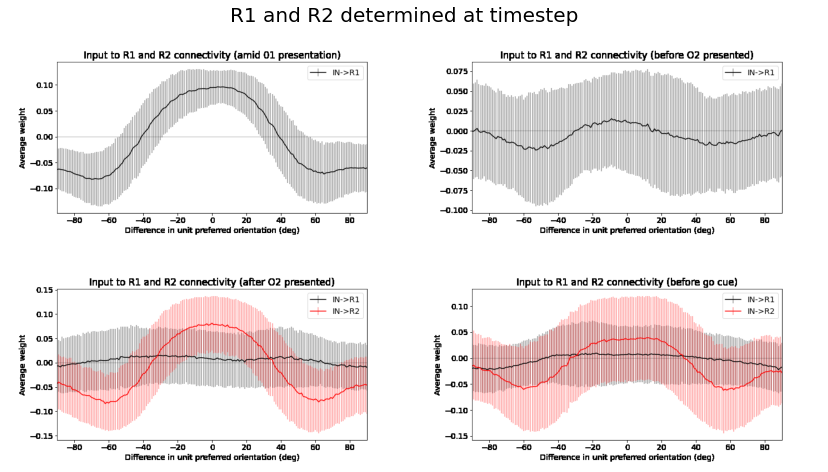

In [65]:
R1_i = megabatch_tuningindices[t5][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t5][R2_starts_from_i:]
imagess = []
for i, x in enumerate([(t1_5, t1_5d), (t3, t3d), (t4, t4d), (t5, t5d)]):
    timestep, timestep_desc = x
    R1_i = megabatch_tuningindices[timestep][:R1_ends_at_i]
    R2_i = megabatch_tuningindices[timestep][R2_starts_from_i:]
    R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
    R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES

    o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph(R1_i, R1_pref, timestep)
    o2_distances, o2_weights, o2_weights_std = get_connplot_iu_graph(R2_i, R2_pref, timestep)
    fig = plt.figure(figsize=(10, 5))
    markers, caps, bars = plt.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    if timestep >= t4:
        markers, caps, bars = plt.errorbar(o2_distances, o2_weights, o2_weights_std, color='r', markersize=10, label="IN->R2", capsize=0)
        [bar.set_alpha(0.4) for bar in bars]
        [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'Input to R1 and R2 connectivity ({timestep_desc})')
    plt.legend()
    plt.xlim(-90, 90)
    imagess.append(plt_to_image(fig))
images_side_by_side(imagess, 
                    save_to=make_saving_path("ring_input_connectivity_2.pdf"), 
                    title="R1 and R2 determined at timestep",
                    figsize=(12, 7))

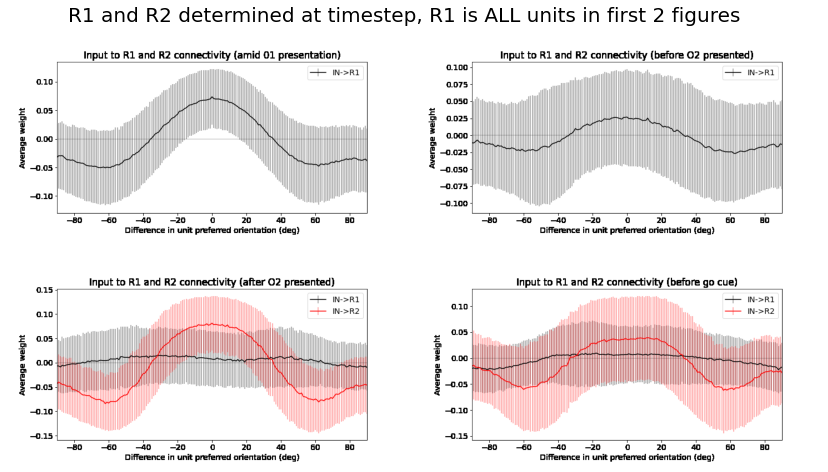

In [66]:
R1_i = megabatch_tuningindices[t5][:R1_ends_at_i]
R2_i = megabatch_tuningindices[t5][R2_starts_from_i:]
imagess = []
for i, x in enumerate([(t1_5, t1_5d), (t3, t3d), (t4, t4d), (t5, t5d)]):
    timestep, timestep_desc = x
    R1_i = megabatch_tuningindices[timestep][:R1_ends_at_i]
    R2_i = megabatch_tuningindices[timestep][R2_starts_from_i:]
    R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
    R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R2_i], dim=1), dim=1)*ORI_RES

    if timestep < t4:
        R1_i = megabatch_tuningindices[timestep]
        R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[timestep][R1_i], dim=2), dim=1)*ORI_RES
    
    o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph(R1_i, R1_pref, timestep)
    o2_distances, o2_weights, o2_weights_std = get_connplot_iu_graph(R2_i, R2_pref, timestep)
    fig = plt.figure(figsize=(10, 5))
    markers, caps, bars = plt.errorbar(o1_distances, o1_weights, o1_weights_std, color='k', markersize=10, label="IN->R1", capsize=0)
    [bar.set_alpha(0.4) for bar in bars]
    [cap.set_alpha(0.4) for cap in caps]
    if timestep >= t4:
        markers, caps, bars = plt.errorbar(o2_distances, o2_weights, o2_weights_std, color='r', markersize=10, label="IN->R2", capsize=0)
        [bar.set_alpha(0.4) for bar in bars]
        [cap.set_alpha(0.4) for cap in caps]
    plt.axhline(y=0.0, color='k', linestyle='-', linewidth=0.3)
    plt.xlabel('Difference in unit preferred orientation (deg)')
    plt.ylabel('Average weight')
    plt.title(f'Input to R1 and R2 connectivity ({timestep_desc})')
    plt.legend()
    plt.xlim(-90, 90)
    imagess.append(plt_to_image(fig))
images_side_by_side(imagess, 
                    save_to=make_saving_path("ring_input_connectivity_3.pdf"), 
                    title="R1 and R2 determined at timestep, R1 is ALL units in first 2 figures",
                    figsize=(12, 7))

## Overlap with R1 and R2

findfont: Font family ['Ariel'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ariel'] not found. Falling back to DejaVu Sans.


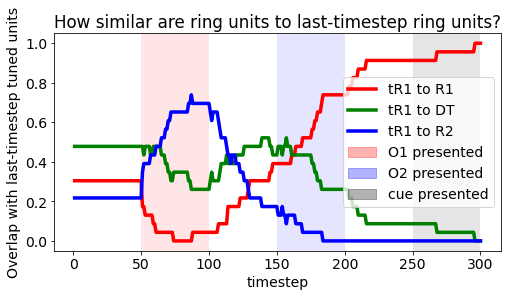

In [279]:
R1_indices = megabatch_tuningindices[:, :R1_ends_at_i]
DT_indices = megabatch_tuningindices[:, R1_ends_at_i:R2_starts_from_i]
R2_indices = megabatch_tuningindices[:, R2_starts_from_i:]
intersection_size_tr1_r1 = [np.intersect1d(R1_indices[-1], R1_indices[t]).shape[0]/R1_indices[-1].shape[0] for t in range(total_time)]
intersection_size_tr1_dt = [np.intersect1d(DT_indices[-1], R1_indices[t]).shape[0]/R1_indices[-1].shape[0] for t in range(total_time)]
intersection_size_tr1_r2 = [np.intersect1d(R2_indices[-1], R1_indices[t]).shape[0]/R1_indices[-1].shape[0] for t in range(total_time)]
intersection_size_r2 = [np.intersect1d(R2_indices[-1], R2_indices[t]).shape[0]/R2_indices[-1].shape[0] for t in range(total_time)]
time = range(1, total_time+1)

font = {'family' : 'Ariel',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.figure(figsize=(8, 4))
plt.plot(time, intersection_size_tr1_r1, "r-", linewidth=3.5, markersize=10, label="tR1 to R1")
plt.plot(time, intersection_size_tr1_dt, "g-", linewidth=3.5, markersize=10, label="tR1 to DT")
plt.plot(time, intersection_size_tr1_r2, "b-", linewidth=3.5, markersize=10, label="tR1 to R2")
#plt.plot(time, intersection_size_r2, "b-", linewidth=3.5, markersize=10, label="R2 units")
plt.xlabel('timestep')
plt.ylabel('Overlap with last-timestep tuned units')
plt.title(f'How similar are ring units to last-timestep ring units?')
plt.legend()
annotate_task_on_plt(plt)
plt.savefig(make_saving_path("R1_similarity.pdf"), bbox_inches='tight')

## PCA

In [280]:
from sklearn.decomposition import PCA

R1_i = megabatch_tuningindices[-1][:R1_ends_at_i]
DT_i = megabatch_tuningindices[-1][R1_ends_at_i:R2_starts_from_i]
R2_i = megabatch_tuningindices[-1][R2_starts_from_i:]
R1_pref = torch.argmax(torch.sum(megabatch_tuningdata[-1][R1_i], dim=2), dim=1)*ORI_RES
R2_pref = torch.argmax(torch.sum(megabatch_tuningdata[-1][R2_i], dim=1), dim=1)*ORI_RES

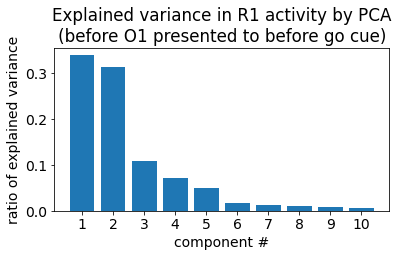

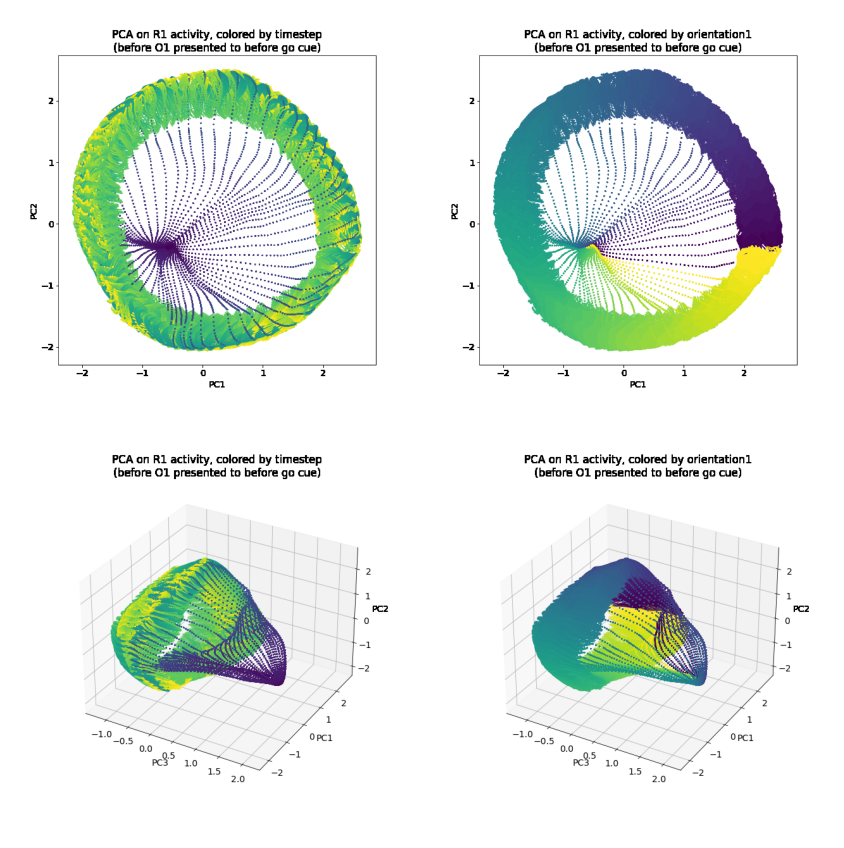

In [293]:
t_from, t_from_d = t1, t1d
t_to, t_to_d = t5, t5d

#timestep_from, timestep_to = 0, 300

indices = torch.cat((R1_i,))
activity_of = "R1"
                    
arr = megabatch_output[1].clone()[:, t_from:t_to, :].reshape(-1, dim_recurrent)
#arr = arr[:, torch.cat((R1_i, DT_i))]#R2_indices[-1]]
arr = arr[:, indices]#R2_indices[-1]]
arr = arr.cpu().detach().numpy()

pca = PCA(n_components=10, svd_solver='full')
arr_pca = pca.fit_transform(arr)

fig = plt.figure(figsize=(6, 3))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.title(f"Explained variance in {activity_of} activity by PCA\n({t_from_d} to {t_to_d})")
plt.xlabel("component #")
plt.ylabel("ratio of explained variance")
plt.xticks(range(1, len(pca.explained_variance_ratio_)+1))
plt.savefig(make_saving_path(f"pca_{activity_of}_{t_from}to{t_to}_explainedvariance.pdf"), bbox_inches='tight')
plt.show()

arr_pca.shape
res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
#res = res[:, :, :]
c = [t for o1 in range(res.shape[0]) for o2 in range(res.shape[1]) for t in range(res.shape[2])]
res = res.reshape(-1, 10)
fig = plt.figure(figsize=(9, 9))
#ax = fig.add_subplot()
ax = fig.add_subplot()
#ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
#ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
#ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
ax.scatter(res[:, 0], res[:, 1], c=c, s=1)
#ax.set_xlim(-3, 3)
#ax.set_ylim(-4.5, 5)
#ax.legend()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(f"PCA on {activity_of} activity, colored by timestep\n({t_from_d} to {t_to_d})")
im1 = plt_to_image(fig)

arr_pca.shape
res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
res = res[:, :, :]
c = [o1 for o1 in range(res.shape[1]) for o2 in range(res.shape[0]) for t in range(res.shape[2])]
res = res.reshape(-1, 10)
fig = plt.figure(figsize=(9, 9))
#ax = fig.add_subplot()
ax = fig.add_subplot()
#ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
#ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
#ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
ax.scatter(res[:, 0], res[:, 1], c=c, s=1)
#ax.set_xlim(-3, 3)
#ax.set_ylim(-4.5, 5)
#ax.legend()
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(f"PCA on {activity_of} activity, colored by orientation1\n({t_from_d} to {t_to_d})")
im2 = plt_to_image(fig)

arr_pca.shape
res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
res = res[:, :, :]
c = [t for o1 in range(res.shape[1]) for o2 in range(res.shape[0]) for t in range(res.shape[2])]
res = res.reshape(-1, 10)
fig = plt.figure(figsize=(9, 9))
#ax = fig.add_subplot()
ax = fig.add_subplot(projection='3d')
#ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
#ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
#ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
ax.scatter(res[:, 2], res[:, 0], res[:, 1], c=c, s=1)
#ax.set_xlim(-3, 3)
#ax.set_ylim(-4.5, 5)
#ax.legend()
ax.set_xlabel("PC3")
ax.set_ylabel("PC1")
ax.set_zlabel("PC2")
ax.set_title(f"PCA on {activity_of} activity, colored by timestep\n({t_from_d} to {t_to_d})")
im3 = plt_to_image(fig)

arr_pca.shape
res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
res = res[:, :, :]
c = [o1 for o1 in range(res.shape[0]) for o2 in range(res.shape[1]) for t in range(res.shape[2])]
res = res.reshape(-1, 10)
fig = plt.figure(figsize=(9, 9))
#ax = fig.add_subplot()
ax = fig.add_subplot(projection='3d')
#ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
#ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
#ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
ax.scatter(res[:, 2], res[:, 0], res[:, 1], c=c, s=1)
#ax.set_xlim(-3, 3)
#ax.set_ylim(-4.5, 5)
#ax.legend()
ax.set_xlabel("PC3")
ax.set_ylabel("PC1")
ax.set_zlabel("PC2")
ax.set_title(f"PCA on {activity_of} activity, colored by orientation1\n({t_from_d} to {t_to_d})")
im4 = plt_to_image(fig)

images_side_by_side((im1, im2, im3, im4), save_to=make_saving_path(f"pca_{activity_of}_{t_from}to{t_to}_plots.pdf"))

### Videos of PCA

In [294]:
def get_title(timestep):
    if timestep >= hold_orientation_for*2+hold_cue_for+delay0+delay1+delay2:
        return "cue2 presented"
    if timestep >= hold_orientation_for*2+delay0+delay1+delay2:
        return "cue1 presented"
    if timestep >= hold_orientation_for*2+delay0+delay1:
        return "delay2"
    if timestep >= hold_orientation_for+delay0+delay1:
        return "orientation2 presented"
    if timestep >= hold_orientation_for+delay0:
        return "delay1"
    if timestep >= delay0:
        return "orientation1 presented"
    return "delay0"

1(0.50%) 11(5.50%) 21(10.50%) 31(15.50%) 41(20.50%) 51(25.50%) 61(30.50%) 71(35.50%) 81(40.50%) 91(45.50%) 101(50.50%) 111(55.50%) 121(60.50%) 131(65.50%) 141(70.50%) 151(75.50%) 161(80.50%) 171(85.50%) 181(90.50%) 191(95.50%) 

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5

0

00] Weighted P-Frames: Y:0.0% UV:0.0%
[libx264 @ 0x7ffcb0819200] ref P L0: 70.0% 15.0%  9.2%  5.8%
[libx264 @ 0x7ffcb0819200] ref B L0: 90.2%  8.2%  1.6%
[libx264 @ 0x7ffcb0819200] ref B L1: 98.6%  1.4%
[libx264 @ 0x7ffcb0819200] kb/s:234.02


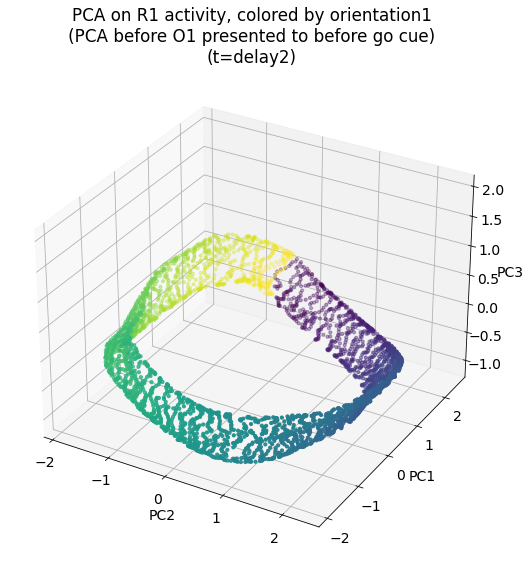

In [297]:
dirname = f"PCA_{activity_of}_fixed"
import pathlib
_path = pathlib.Path(f"{directory}/{index}/{dirname}/file.png")
_path.parent.mkdir(parents=True, exist_ok=True)
for a in range(t_from, t_to):
    res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
    t = -t1+a
    res = res[:, :, t:t+1, :]
    c = [o1 for o1 in range(res.shape[1]) for o2 in range(res.shape[0]) for t in range(res.shape[2])]
    res = res.reshape(-1, 10)
    plt.close('all')
    fig = plt.figure(figsize=(9, 9))
    #ax = fig.add_subplot()
    ax = fig.add_subplot(projection='3d')
    #ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
    #ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
    #ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
    ax.scatter(res[:, 1], res[:, 0], res[:, 2], c=c, s=10)
    ax.set_xlim(np.min(arr_pca, axis=0)[1], np.max(arr_pca, axis=0)[1])
    ax.set_ylim(np.min(arr_pca, axis=0)[0], np.max(arr_pca, axis=0)[0])
    ax.set_zlim(np.min(arr_pca, axis=0)[2], np.max(arr_pca, axis=0)[2])
    ax.set_xlabel("PC2")
    ax.set_ylabel("PC1")
    ax.set_zlabel("PC3")
    ax.set_title(f"PCA on {activity_of} activity, colored by orientation1\n(PCA {t_from_d} to {t_to_d})"+
                 f"\n(t={get_title(a)})")

    plt.savefig(f"{directory}/{index}/{dirname}/fig{a:03}.png", bbox_inches='tight')
    if a % 10 == 0: print(f"{t}({(a-t_from)/(t_to-t_from)*100:.2f}%)", end=" ")
os.system(f"ffmpeg -framerate 10 -y -pattern_type glob -i '{directory}/{index}/{dirname}/*.png' -c:v libx264 -pix_fmt yuv420p {directory}/{index}/{dirname}.mp4")

1(0.50%) 11(5.50%) 21(10.50%) 31(15.50%) 41(20.50%) 51(25.50%) 61(30.50%) 71(35.50%) 81(40.50%) 91(45.50%) 101(50.50%) 111(55.50%) 121(60.50%) 131(65.50%) 141(70.50%) 151(75.50%) 161(80.50%) 171(85.50%) 181(90.50%) 191(95.50%) 

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5

0

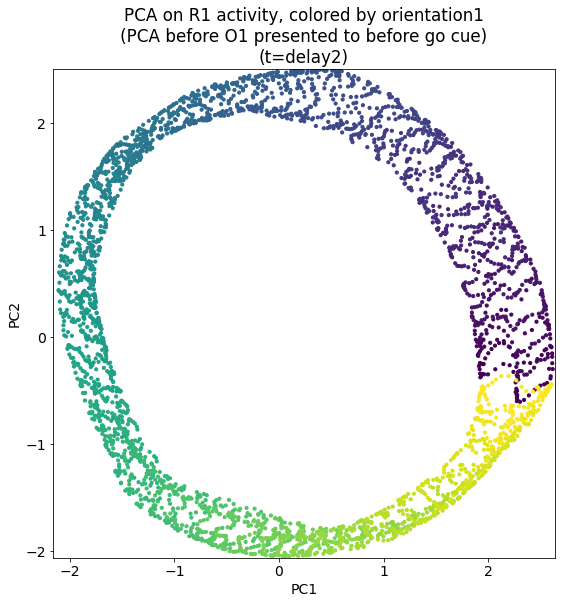

In [298]:
dirname = f"PCA_{activity_of}_2d_fixed"
import pathlib
_path = pathlib.Path(f"{directory}/{index}/{dirname}/file.png")
_path.parent.mkdir(parents=True, exist_ok=True)
for a in range(t_from, t_to):
    res = arr_pca.reshape(180//ORI_RES, 180//ORI_RES, t_to-t_from, 10)
    t = -t1+a
    res = res[:, :, t:t+1, :]
    c = [o1 for o1 in range(res.shape[1]) for o2 in range(res.shape[0]) for t in range(res.shape[2])]
    res = res.reshape(-1, 10)
    plt.close('all')
    fig = plt.figure(figsize=(9, 9))
    #ax = fig.add_subplot()
    ax = fig.add_subplot()
    #ax.scatter(tsne_result[:len(R1_indices[-1]), 0], tsne_result[:len(R1_indices[-1]), 1], color='r', label="R1 units")
    #ax.scatter(tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 0], tsne_result[len(R1_indices[-1]):len(R1_indices[-1])+len(DT_indices[-1]), 1], color='g', label="DT units")
    #ax.scatter(tsne_result[-len(R2_indices[-1]):, 0], tsne_result[-len(R2_indices[-1]):, 1], color='b', label="R2 units")
    ax.scatter(res[:, 0], res[:, 1], c=c, s=10)
    ax.set_xlim(np.min(arr_pca, axis=0)[0], np.max(arr_pca, axis=0)[0])
    ax.set_ylim(np.min(arr_pca, axis=0)[1], np.max(arr_pca, axis=0)[1])
    #ax.set_zlim(np.min(arr_pca, axis=0)[2], np.max(arr_pca, axis=0)[2])
    #ax.legend()
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA on {activity_of} activity, colored by orientation1\n(PCA {t_from_d} to {t_to_d})"+
                 f"\n(t={get_title(a)})")

    plt.savefig(f"{directory}/{index}/{dirname}/fig{a:03}.png", bbox_inches='tight')
    if a % 10 == 0: print(f"{t}({(a-t_from)/(t_to-t_from)*100:.2f}%)", end=" ")
os.system(f"ffmpeg -framerate 10 -y -pattern_type glob -i '{directory}/{index}/{dirname}/*.png' -c:v libx264 -pix_fmt yuv420p {directory}/{index}/{dirname}.mp4")

## o_spikes

In [409]:
def o_spikes(pref, stim, exponent, maxSpike, k):
    # o_spikes: spike numbers per trial for orientation tuning cells
    # r = o_spikes(pref, stim, exponent, k) 
    # pref: row vec for cells' preferred orientations
    # stim: column vec for stimulus orientations
    # exponent: scalar determining the widths of tuning. larger value for sharper tuning
    # maxSpike: scalar for mean max spike number when pref = stim
    # k: scalar for determining variance = k * mean
    # spikes: different columuns for cells with different pref orintations
    #         different rows for different stim orientations
    np_ = pref.shape[0]# number of elements in pref
    ns = stim.shape[0]# number of elements in stim
    
    prefs = np.ones((ns,1)) @ pref[None,:]# ns x np array, (ns x 1) @ (1 x np) 
    stims = stim[:,None] @ np.ones((1,np_))# ns x np array, (ns x 1) @ (1 x np) 
    
    # mean spike numbers
    meanSpike = maxSpike * (0.5*(np.cos(2*(prefs-stims)) + 1)) ** exponent# ns x np array
    
    # sigma for noise
    sigmaSpike = np.sqrt(k * meanSpike)
    
    #spikes = normrnd(meanSpike, sigmaSpike)# ns x np array, matlab
    spikes = np.random.normal(meanSpike, sigmaSpike)# ns x np array, python
    
    # no negative spike numbers
    spikes[spikes < 0] = 0# ns x np array
    return spikes

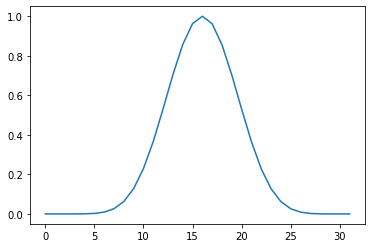

In [420]:
pref = np.pi * np.arange(orientation_neurons) / orientation_neurons
stim = np.array([90 / 180 * 3.14])
exponent = 4
maxSpike = 1
k = 0
plt.plot(range(32), o_spikes(pref, stim, exponent, maxSpike, k)[0])